<a href="https://colab.research.google.com/github/filipe-research/tutorial_noisylabels/blob/main/codes/tutorial_sibgrapi20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: How to train your model when you cannot trust onthe annotations? - SIGBRAPI 2020

Authors: Filipe Cordeiro, Gustavo Carneiro\
github: https://github.com/filipe-research/tutorial_noisylabels

DATASET: 
"MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)


<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>

# Setup

import libraries, hyperparameters and main methods

In [62]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
import seaborn as sn
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#@title Define Hyperparameters

training_size= 2000
num_epochs = 50 # number of times which the entire dataset is passed throughout the model
batch_size = 128 # the size of input data took for one iteration
lr = 1e-3 # size of step
seed=123

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [115]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

In [116]:
# Reduce training size  (just for fast training during the tutorial)
train_data.data = train_data.data[:training_size]
train_data.targets = train_data.targets[:training_size]

In [117]:
#generate dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True,num_workers=4,pin_memory=True)

eval_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = False,num_workers=4,pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False,num_workers=4)

In [ ]:
#plot images of dataset

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(10,6))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [119]:
#@title CNN Arquitecture
#CNN Architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return(x)

In [120]:
ce_loss = nn.CrossEntropyLoss().to(device)

In [121]:
#@title test method
def test(net, loss_function, loader):
  net.eval()
  test_loss = 0
  correct = 0
  
  with torch.no_grad():
    for data, target in loader:
      data, target = data.to(device), target.to(device)
      output = net(data)
      test_loss += loss_function(output, target)
      _, pred = torch.max(output, 1)  
      correct += pred.eq(target).cpu().sum().item() 
  acc = 100.*correct/len(loader.dataset)
  test_loss /= len(loader)
  
  return acc, test_loss

In [106]:
#@title evaluate method

def eval(net, loader):
  net.eval()
  
  losses = torch.zeros(len(loader.dataset))    
  CE = nn.CrossEntropyLoss(reduction='none')
  with torch.no_grad():
    for i ,(images,labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = CE(outputs, labels)
        for b in range(images.size(0)):
          idx = batch_size*i+b
          losses[idx]=loss[b] 
  
  losses = (losses-losses.min())/(losses.max()-losses.min())    
  input_loss = losses.reshape(-1,1)

  # fit a two-component GMM to the loss
  gmm = GaussianMixture(n_components=2,max_iter=50,tol=1e-2,reg_covar=5e-4)
  gmm.fit(input_loss)
  prob = gmm.predict_proba(input_loss) 
  prob = prob[:,gmm.means_.argmin()] 
  return losses, prob



In [107]:
def train_epoch(net, loss_function, dataloader, optimizer):
  train_loss = train_acc = correct = 0
  net.train()
  for i ,(images,labels) in enumerate(dataloader):
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    train_loss+= loss
    loss.backward()

    optimizer.step()

    _, pred = torch.max(outputs, 1)  
    correct += pred.eq(labels).cpu().sum().item() 
        
  train_loss/=len(dataloader)
  train_acc=100.*correct/len(dataloader.dataset)
  return train_loss, train_acc

In [108]:
def train_test_model(loss_function):
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  logs={'train_loss':[],'train_acc':[], 'test_loss':[], 'test_acc':[],'eval_loss':[]}

  for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(net, loss_function, train_loader, optimizer)
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)

    eval_loss, _ = eval(net, eval_loader)
    logs['eval_loss'].append(eval_loss)
    
    acc_test, loss_test=test(net, loss_function, test_loader)
    logs['test_loss'].append(loss_test)
    logs['test_acc'].append(acc_test)

    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
  return logs


# Run Baseline

In [ ]:
#run baseline
logs_baseline = train_test_model(ce_loss)

In [ ]:
fig = plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(logs_baseline['train_acc'], label='train', linewidth=2)
plt.plot(logs_baseline['test_acc'], label='test', linewidth=2)
plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');

plt.subplot(1,2,2)
plt.plot(logs_baseline['train_loss'], label='Training loss', linewidth=2)
plt.plot(logs_baseline['test_loss'], label='Validation loss', linewidth=2)
plt.legend(frameon=False)
# plt.grid()
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.ylabel("Loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');


# Generate Noisy MNIST

Build synthetic noise benchmark on MNIST

In [124]:
gt_labels = train_data.targets.clone()   #ground truth labels (clean)

In [125]:
##generate noise

transition = {0:0,2:0,4:7,7:7,1:1,9:1,3:5,5:3,6:6,8:8} # class transition for asymmetric noise

def generate_noise(nr, gt_labels, noise_mode='sym'):
  noise_label = []
  idx = list(range(len(gt_labels)))
  random.shuffle(idx)
  num_noise = int(nr*len(gt_labels))            
  noise_idx = idx[:num_noise]
  for i in range(len(gt_labels)):
      if i in noise_idx:
        if noise_mode=='sym':
          noiselabel = random.randint(0,9)  
          noise_label.append(noiselabel)
        elif noise_mode=='asym':   
          noiselabel = transition[gt_labels[i].item()]
          noise_label.append(noiselabel)                    
      else:    
        noise_label.append(gt_labels[i])  
  return torch.tensor(noise_label)

In [126]:
#generate noisy_benchmark
label_noise={}
label_noise['50_sym']=generate_noise(0.5, gt_labels, 'sym')
label_noise['70_sym']=generate_noise(0.7, gt_labels, 'sym')
label_noise['40_asym']=generate_noise(0.4, gt_labels, 'asym')

In [ ]:
print('real noise rate:{:.2f}'.format((np.array(label_noise['70_sym'])!=np.array(gt_labels)).sum()/len(gt_labels)))

In [ ]:
#plot images of dataset

# train_data.targets = label_noise['70_sym']  #update current labels
train_loader.dataset.targets = label_noise['70_sym'].clone()
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(10,6))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [129]:
noisy_map = np.zeros((10, 10))
nl = label_noise['70_sym']
for i in range(len(gt_labels)):
  noisy_map[int(nl[i])][int(gt_labels[i])] += 1

#calculate de percentage. Divides each element by the sum of the row
percent_map = noisy_map/noisy_map.sum(axis=0, keepdims=True)

In [ ]:
df_cm = pd.DataFrame(percent_map, index = [0,1,2,3,4,5,6,7,8,9],
                  columns = list(range(10)))
plt.figure(figsize = (8,6))

sn.heatmap(df_cm, annot=True)
plt.ylabel('noisy labels')
plt.xlabel('true labels')


In [84]:
unique_elements, counts_elements = np.unique(nl, return_counts=True)
# unique_elements, counts_elements = np.unique(gt_labels, return_counts=True)

In [ ]:
plt.bar(unique_elements,counts_elements)

## Train noisy baseline

In [ ]:
#train with 50% noise rate
train_loader.dataset.targets = label_noise['50_sym'].clone()  #update current labels
logs_nb_50_sym = train_test_model(ce_loss)

In [ ]:
#train with 50% noise rate
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
logs_nb_70_sym = train_test_model(ce_loss)

In [ ]:
#train with 40% asym. noise rate
train_loader.dataset.targets = label_noise['40_asym'].clone()  #update current labels
logs_nb_40_asym = train_test_model(ce_loss)

In [ ]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['train_acc'], label='train_clean', linewidth=2, linestyle='--',color='k')
plt.plot(logs_nb_50_sym['train_acc'], label='train_50_sym', linewidth=2, linestyle='--', color='r')
plt.plot(logs_nb_70_sym['train_acc'], label='train_70_sym', linewidth=2, linestyle='--', color='g')
plt.plot(logs_nb_40_asym['train_acc'], label='train_40_asym', linewidth=2, linestyle='--', color='b')
plt.plot(logs_baseline['test_acc'], label='test_clean', linewidth=2, color='k')
plt.plot(logs_nb_50_sym['test_acc'], label='test_50_sym', linewidth=2, color='r')
plt.plot(logs_nb_70_sym['test_acc'], label='test_70_sym', linewidth=2, color='g')
plt.plot(logs_nb_40_asym['test_acc'], label='test_40_asym', linewidth=2, color='b')
# plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.subplot(1,2,2)
plt.plot(logs_baseline['train_loss'], label='train_clean', linewidth=2, linestyle='--',color='k')
plt.plot(logs_nb_50_sym['train_loss'], label='train_50_sym', linewidth=2, linestyle='--', color='r')
plt.plot(logs_nb_70_sym['train_loss'], label='train_70_sym', linewidth=2, linestyle='--', color='g')
plt.plot(logs_nb_40_asym['train_loss'], label='train_40_asym', linewidth=2, linestyle='--', color='b')
plt.plot(logs_baseline['test_loss'], label='test_clean', linewidth=2, color='k')
plt.plot(logs_nb_50_sym['test_loss'], label='test_50_sym', linewidth=2, color='r')
plt.plot(logs_nb_70_sym['test_loss'], label='test_70_sym', linewidth=2, color='g')
plt.plot(logs_nb_40_asym['test_loss'], label='test_40_asym', linewidth=2, color='b')
# plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.ylabel("Loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');

# Combating Noisy Labels

## Robust Loss

In [130]:
#Active Passive Loss (ICML 2020)
#paper code: https://github.com/HanxunH/Active-Passive-Losses

In [89]:
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes=10, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float()
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

In [90]:
class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * rce.mean()

In [91]:
class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha=0.1, beta=1, num_classes=10):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)

In [92]:
class NormalizedFocalLoss(torch.nn.Module):
    def __init__(self, scale=1.0, gamma=0, num_classes=10, alpha=None, size_average=True):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input, target):
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        normalizor = torch.sum(-1 * (1 - logpt.data.exp()) ** self.gamma * logpt, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        loss = self.scale * loss / normalizor

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [93]:
class NFLandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10, gamma=0.5):
        super(NFLandRCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.rce(pred, labels)

In [94]:
class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        # Note: Reduced MAE
        # Original: torch.abs(pred - label_one_hot).sum(dim=1)
        # $MAE = \sum_{k=1}^{K} |\bm{p}(k|\bm{x}) - \bm{q}(k|\bm{x})|$
        # $MAE = \sum_{k=1}^{K}\bm{p}(k|\bm{x}) - p(y|\bm{x}) + (1 - p(y|\bm{x}))$
        # $MAE = 2 - 2p(y|\bm{x})$
        #
        return self.scale * mae.mean()

In [95]:
class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

### Train with APL 

In [ ]:
#train with 70% noise rate
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
criterion =NCEandMAE(alpha=1, beta=1)
logs_apl_70_sym = train_test_model(criterion)

In [ ]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['test_acc'], label='test_baseline_clean', linewidth=2, color='k')
plt.plot(logs_nb_70_sym['test_acc'], label='test_baseline_70_sym', linewidth=2, color='r')
plt.plot(logs_apl_70_sym['test_acc'], label='test__APL_70_sym', linewidth=2, color='b')
# plt.plot(logs_nb_40_asym['test_acc'], label='test_40_asym', linewidth=2, color='b')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)
plt.ylim(70, 100,10)


### small-loss trick

In [40]:
# noisy_labels = label_noise['70_sym']
nl = label_noise['70_sym']
inds_noisy = np.asarray([ind for ind in range(len(nl)) if nl[ind] != gt_labels[ind]])
inds_clean = np.delete(np.arange(len(nl)), inds_noisy)

In [ ]:
plt.hist(logs_nb_70_sym['eval_loss'][-1][inds_noisy],label='noisy',bins=100,alpha=0.5)
plt.hist(logs_nb_70_sym['eval_loss'][-1][inds_clean],label='clean',bins=100,alpha=0.5)
plt.xlabel("Normalized loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend()

In [43]:
avg_loss_clean = [logs_nb_70_sym['eval_loss'][i][inds_clean].mean() for i in range(num_epochs)]
avg_loss_noisy = [logs_nb_70_sym['eval_loss'][i][inds_noisy].mean() for i in range(num_epochs)]

In [ ]:
plt.plot(avg_loss_clean, label='clean',linewidth=2)
plt.plot(avg_loss_noisy, label='noisy',linewidth=2)
plt.ylabel("Avg. Loss", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend()

## Remove Noisy Samples

In [133]:
def train_test_filtering(loss_function,trainloader):
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  logs={'train_loss':[],'train_acc':[], 'test_loss':[], 'test_acc':[],'eval_loss':[]}

  for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(net, loss_function, trainloader, optimizer)
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    eval_loss, prob = eval(net, eval_loader)
    logs['eval_loss'].append(eval_loss)
    
    acc_test, loss_test=test(net, loss_function, test_loader)
    logs['test_loss'].append(loss_test)
    logs['test_acc'].append(acc_test)

    if epoch>10:
      pred_idx_clean = (prob > 0.5).nonzero()[0]
      
      train_clean = Subset(train_data, pred_idx_clean)    #get the subset of samples predicted as clean
      clean_loader = torch.utils.data.DataLoader(train_clean,
                                              batch_size = batch_size,
                                              shuffle = True,num_workers=4,pin_memory=True)
      trainloader=clean_loader

    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
  
  return logs

In [ ]:
#train with 70% sym noise
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
logs_remove_70_sym = train_test_filtering(ce_loss,train_loader)

In [ ]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['test_acc'], label='test_baseline_clean', linewidth=2, color='k')
plt.plot(logs_nb_70_sym['test_acc'], label='test_baseline_70_sym', linewidth=2, color='r')
plt.plot(logs_apl_70_sym['test_acc'], label='test__APL_70_sym', linewidth=2, color='b')
plt.plot(logs_remove_70_sym['test_acc'], label='test_remove_70_sym', linewidth=2, color='g')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)
plt.ylim(70, 100,10)

In [ ]:
# combine removal with apl loss
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
logs_remove_apl_70_sym = train_test_filtering(criterion,train_loader)

In [ ]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(logs_baseline['test_acc'], label='test_baseline_clean', linewidth=2, color='k')
plt.plot(logs_nb_70_sym['test_acc'], label='test_baseline_70_sym', linewidth=2, color='r')
plt.plot(logs_remove_apl_70_sym['test_acc'], label='test_rem_APL_70_sym', linewidth=2, color='b')
plt.plot(logs_remove_70_sym['test_acc'], label='test_remove_70_sym', linewidth=2, color='g')
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)
plt.ylim(70, 100,10)

## Data augmentation (Mixup)

In [566]:
def train_epoch_mixup(net, loss_function, dataloader_clean, dataloader_noisy, optimizer):
  train_loss = train_acc = correct = 0
  net.train()
  for i ,(images,labels) in enumerate(dataloader_clean):
    
    

    targets_x = torch.zeros(images.size(0), 10).scatter_(1, labels.view(-1,1), 1)
    images = images.to(device)
    # labels = labels.to(device)
    targets_x = targets_x.to(device)
    labels = labels.to(device)
    try:
      unlabeled_train_iter = iter(dataloader_noisy)
      inputs_u, targets_u = unlabeled_train_iter.next() 
      inputs_u = inputs_u.to(device)
      targets_u = torch.zeros(images.size(0), 10).scatter_(1, targets_u.view(-1,1), 1).cuda()
    except:
      print('error')

    
    optimizer.zero_grad()
    outputs = net(images)

    with torch.no_grad():
      outputs_u = net(inputs_u)
      pu = torch.softmax(outputs_u, dim=1)
      # pu = pu**(1/0.5) # temparature sharpening
#           targets_u = ptu / ptu.sum(dim=1, keepdim=True) # normalize
      labels_u2 = torch.max(outputs_u,1)[1]
      targets_u2 = torch.zeros(images.size(0), 10).to(device).scatter_(1, labels_u2.view(-1,1), 1)

    # mixmatch
    l = np.random.beta(4, 4)        
    l = max(l, 1-l)

    all_inputs = torch.cat([images, images ], dim=0)
    all_targets = torch.cat([targets_x, targets_x], dim=0)
    idx = torch.randperm(all_inputs.size(0))
    # idx = torch.randperm(images.size(0))

    input_a, input_b = all_inputs, all_inputs[idx]
    target_a, target_b = all_targets, all_targets[idx]
              
    mixed_input = l * input_a + (1 - l) * input_b        
    # mixed_input = l * images + (1 - l) * inputs_u        
    mixed_target = l * target_a + (1 - l) * target_b
    # mixed_target = l * targets_x + (1 - l) * targets_u2
    # mixed_target = l * targets_x + (1 - l) * targets_u

    outputsa = net(mixed_input)
    outputs = net(images)

    #loss = loss_function(outputs, labels)
    # loss = loss_function(outputs, labels)
    # lx = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * mixed_target, dim=1))
    # loss2 = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * mixed_target, dim=1))
    lxa = -torch.mean(torch.sum(F.log_softmax(outputsa, dim=1) * mixed_target, dim=1))
    lx = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * targets_x, dim=1))
    lu = -torch.mean(torch.sum(pu.log()*pu, dim=1)) #entropy
    loss = lxa+lx + lu
    train_loss+= loss 
    loss.backward()

    optimizer.step()

    _, pred = torch.max(outputs, 1)  
    # import pdb; pdb.set_trace()
    #correct += pred.eq(labels).cpu().sum().item() 
    #correct += pred.eq(labels).cpu().sum().item() 
    # correct += pred.eq(mixed_target).cpu().sum().item() 
    correct=0
    # correct += pred.eq(labels).sum().item() 
        
  train_loss/=len(dataloader_clean)
  train_acc=100.*correct/len(dataloader_clean.dataset)
  return train_loss, train_acc

In [567]:
def train_test_mixup(loss_function,trainloader):
  torch.manual_seed(seed)
  net = Net()
  net = net.to(device)
  optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

  logs={'train_loss':[],'train_acc':[], 'test_loss':[], 'test_acc':[],'eval_loss':[]}

  for epoch in range(num_epochs):
    if epoch <=15:
      train_loss, train_acc = train_epoch(net, loss_function, trainloader, optimizer)
    else:
      train_loss, train_acc = train_epoch_mixup(net, loss_function, clean_loader, noisy_loader, optimizer)

    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    eval_loss, prob = eval(net, eval_loader)
    logs['eval_loss'].append(eval_loss)
    
    acc_test, loss_test=test(net, loss_function, test_loader)
    logs['test_loss'].append(loss_test)
    logs['test_acc'].append(acc_test)

    if epoch>=15:
      pred_idx_clean = (prob > 0.5).nonzero()[0]
      pred_idx_noisy = (prob <= 0.5).nonzero()[0]
      
      train_clean = Subset(train_data, pred_idx_clean)    #get the subset of samples predicted as clean
      clean_loader = torch.utils.data.DataLoader(train_clean,
                                              batch_size = batch_size,
                                              shuffle = True,num_workers=2,pin_memory=True, drop_last=True)
      train_noisy = Subset(train_data, pred_idx_noisy)
      noisy_loader = torch.utils.data.DataLoader(train_noisy,
                                              batch_size = batch_size, drop_last=True,
                                              shuffle = True,num_workers=2,pin_memory=True)
      
      trainloader=clean_loader

    print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
  # return log_losses_train, log_losses_test, log_acc_train, log_acc_test, log_losses_eval
  return logs

In [ ]:
train_loader.dataset.targets = label_noise['70_sym'].clone()  #update current labels
# losses_train30, losses_test30, acc_train_log30, acc_test_log30, all_loss_idx_30 = train(ce_loss)
logs_mixup_70_sym = train_test_mixup(ce_loss,train_loader)

Epoch [0/40],	train loss:2.3099,	train acc:10.70,	test loss:2.2753,	test accuracy:17.55
Epoch [1/40],	train loss:2.2897,	train acc:12.35,	test loss:2.2339,	test accuracy:31.56


(70.0, 100.0)

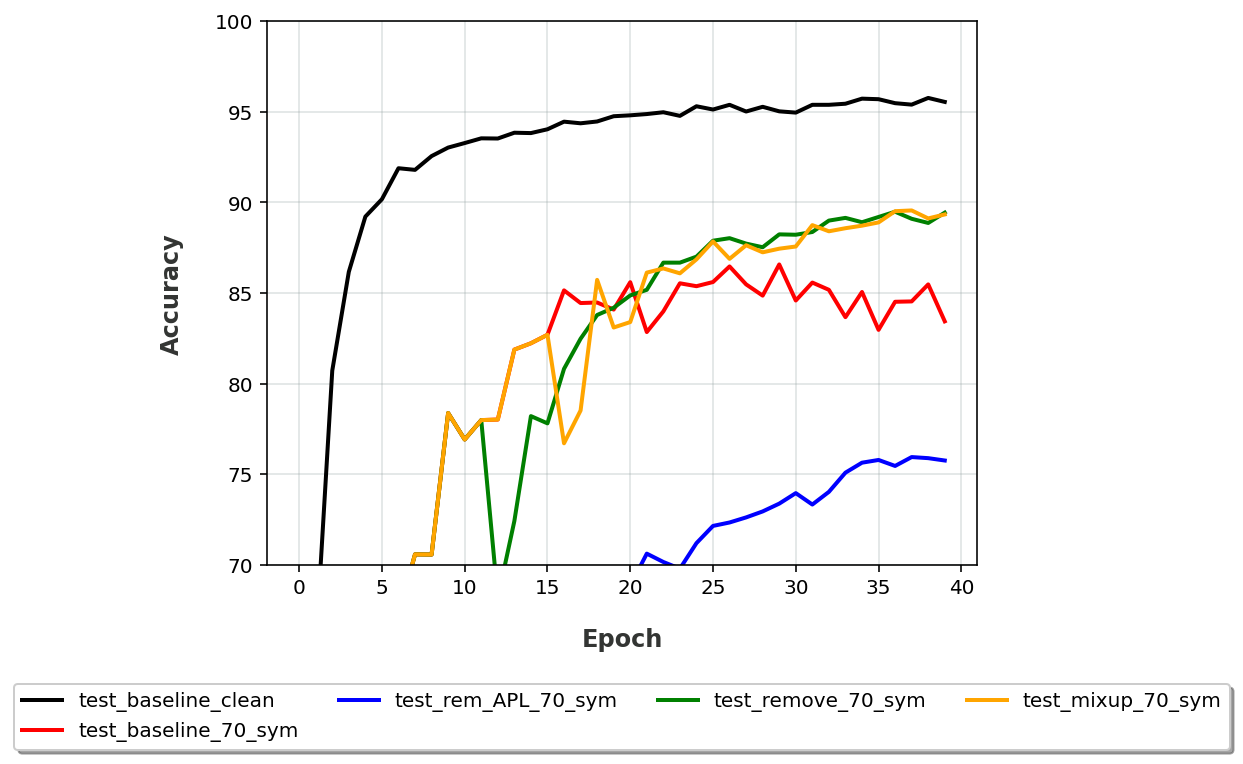

In [563]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
# plt.plot(logs_baseline['train_acc'], label='train_baseline_clean', linewidth=2, linestyle='--',color='k')
# plt.plot(logs_nb_70_sym['train_acc'], label='train_baseline_70_sym', linewidth=2, linestyle='--', color='r')
# plt.plot(logs_apl_70_sym['train_acc'], label='train_APL_70_sym', linewidth=2, linestyle='--', color='b')
# plt.plot(logs_nb_40_asym['train_acc'], label='train_40_asym', linewidth=2, linestyle='--', color='b')
plt.plot(logs_baseline['test_acc'], label='test_baseline_clean', linewidth=2, color='k')
plt.plot(logs_nb_70_sym['test_acc'], label='test_baseline_70_sym', linewidth=2, color='r')
plt.plot(logs_remove_apl_70_sym['test_acc'], label='test_rem_APL_70_sym', linewidth=2, color='b')
plt.plot(logs_remove_70_sym['test_acc'], label='test_remove_70_sym', linewidth=2, color='g')
plt.plot(logs_mixup_70_sym['test_acc'], label='test_mixup_70_sym', linewidth=2, color='orange')
# plt.plot(logs_nb_40_asym['test_acc'], label='test_40_asym', linewidth=2, color='b')
# plt.legend(frameon=False)
plt.grid(True, color="#93a1a1", alpha=0.3)
plt.ylabel("Accuracy", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.xlabel("Epoch", labelpad=15, fontsize=12, color="#333533", fontweight='bold');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)
plt.ylim(70, 100,10)

### gmm + data augm (mixup)

In [31]:
# #@title Training the model filter
# import os
# from torch.utils.data import Subset
# CE = nn.CrossEntropyLoss(reduction='none')
# def train_mixup(loss_function):
  
  
#   # os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#   #initialize network
#   torch.manual_seed(seed)
#   net = Net()
#   net = net.to(device)
#   optimizer = torch.optim.Adam( net.parameters(), lr=lr) 

#   losses_train=[]
#   losses_test=[]
#   acc_train_log=[]
#   acc_test_log=[]
#   all_losses=[]

  
#   clean_gen = train_gen
#   #for epoch in range(num_epochs):
#   wm=15
#   for epoch in range(num_epochs):
#     train_loss = train_acc = correct = 0
#     net.train()
#     count=0
#     if epoch>wm:
#       unlabeled_train_iter = iter(noisy_gen) 
    
#     for i ,(images,targets_x) in enumerate(clean_gen):
#       count+=images.size(0)
#       #images = Variable(images.view(-1,28*28)).cuda()
#       #images = images.view(-1,28*28).to(device)
#       inputs_x = images.to(device)

#       targets_x = torch.zeros(images.size(0), 10).scatter_(1, targets_x.view(-1,1), 1)
#       targets_x = targets_x.to(device)
#       # targets_x = labels.to(device)

#       optimizer.zero_grad()
#       outputs = net(inputs_x)
      
#       if epoch<=wm:
#         # loss = loss_function(outputs, targets_x)
#         outputs = net(inputs_x) 
#         loss = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * targets_x, dim=1))
#       else:

#         try:
#           inputs_u, _ = unlabeled_train_iter.next()
#         except:
#           unlabeled_train_iter = iter(noisy_gen)
#           inputs_u, _ = unlabeled_train_iter.next()  
#         inputs_u = inputs_u.to(device)

#         with torch.no_grad():
#           outputs_u = net(inputs_u)
#           pu = torch.softmax(outputs_u, dim=1)
#           ptu = pu**(1/0.5) # temparature sharpening
#           targets_u = ptu / ptu.sum(dim=1, keepdim=True) # normalize
#           # targets_u=ptu
#         # targets_u = targets_u.detach()

#         # join_input = torch.cat([inputs_x, inputs_u], dim=0)
#         # join_outputs = net(join_input)  
#         # outputs= join_outputs[:batch_size]
#         # outputs_u= join_outputs[batch_size:]
#         # pu = torch.softmax(outputs_u, dim=1)

#         # mixmatch
#         l = np.random.beta(4, 4)        
#         l = max(l, 1-l)

#         all_inputs = torch.cat([inputs_x,inputs_x, inputs_u,inputs_u ], dim=0)
#         # print(inputs_x.size(0),inputs_u.size(0))
#         # print(targets_x.shape,targets_u.shape)
#         # print(targets_x)
#         # print(targets_u)
#         all_targets = torch.cat([targets_x,targets_x, targets_u,targets_u], dim=0)

#         idx = torch.randperm(all_inputs.size(0))

#         input_a, input_b = all_inputs, all_inputs[idx]
#         target_a, target_b = all_targets, all_targets[idx]
              
#         mixed_input = l * input_a + (1 - l) * input_b        
#         mixed_target = l * target_a + (1 - l) * target_b
                      
#         logits = net(mixed_input)
#         logits_x = logits[:batch_size*2]
#         logits_u = logits[batch_size*2:] 

#         target_x = mixed_target[:batch_size*2]
#         # target_x = targets_x
#         # targets_u= mixed_target[batch_size:]

#         # probs_u = torch.softmax(logits_u, dim=1)
#         Lx = -torch.mean(torch.sum(F.log_softmax(logits_x, dim=1) * mixed_target[:batch_size*2], dim=1))
#         # Lx = -torch.mean(torch.sum(F.log_softmax(outputs, dim=1) * target_x, dim=1))
#         #Lu = torch.mean((probs_u - targets_u)**2) 
#         Lu = -torch.mean(torch.sum(pu.log()*pu, dim=1)) #entropy
        
        
#         #loss = loss_function(outputs, labels)
#         loss = Lx + 0*Lu
#       # if epoch>0:
#       #   print('enter')
#       #   loss = CE(outputs, labels)
#       #   loss = loss[idx_pred_c].mean()
#       train_loss+= loss
#       loss.backward()

#       optimizer.step()

#       _, pred = torch.max(outputs, 1)  
#       # correct += pred.eq(targets_x).cpu().sum().item() 
#       correct = 0
      
#     print(count)
#     train_loss/=len(clean_gen)
#     train_acc=100.*correct/len(clean_gen.dataset)

#     losses_train.append(train_loss)
#     acc_train_log.append(train_acc)

#     # all_losses.append(eval(net))
#     losses, prob = eval(net)
#     all_losses.append(losses)

#     if epoch>=wm:
#       pred_idx_clean = (prob > 0.5).nonzero()[0]
#       pred_idx_noisy = (prob <= 0.5).nonzero()[0]
      
#       train_clean = Subset(train_data, pred_idx_clean)
#       train_noisy = Subset(train_data, pred_idx_noisy)
#       # clean_dataset.data = train_data.data[inds_clean]
#       clean_gen = torch.utils.data.DataLoader(train_clean,
#                                               batch_size = batch_size, drop_last=True,
#                                               shuffle = True,num_workers=8,pin_memory=True)
#       noisy_gen = torch.utils.data.DataLoader(train_noisy,
#                                               batch_size = batch_size, drop_last=True,
#                                               shuffle = True,num_workers=8,pin_memory=True)

#     # import pdb;pdb.set_trace()
#     # idx_pred_c = (noisy_labels==gt_labels).nonzero()[0]
#     # idx_pred_c = inds_clean
#     # import pdb; pdb.set_trace()
#     acc_test, loss_test=test(net, loss_function)
#     losses_test.append(loss_test)
#     acc_test_log.append(acc_test)
#     print('Epoch [{}/{}],\ttrain loss:{:.4f},\ttrain acc:{:.2f},\ttest loss:{:.4f},\ttest accuracy:{:.2f}'.format(epoch,num_epochs,train_loss,train_acc, loss_test, acc_test))
#     #testing
    
#   return losses_train, losses_test, acc_train_log, acc_test_log, all_losses


In [32]:
train_data.targets = noisy_labels70  #update current labels
losses_train70_F, losses_test70_F, acc_train_log70_F, acc_test_log70_F, all_loss_idx_F = train_mixup(ce_loss)

5000
Epoch [0/40],	train loss:2.3040,	train acc:0.00,	test loss:2.2522,	test accuracy:36.06
5000
Epoch [1/40],	train loss:2.2816,	train acc:0.00,	test loss:2.1325,	test accuracy:62.85
5000
Epoch [2/40],	train loss:2.2465,	train acc:0.00,	test loss:1.9351,	test accuracy:80.39
5000
Epoch [3/40],	train loss:2.2220,	train acc:0.00,	test loss:1.8751,	test accuracy:72.05
5000
Epoch [4/40],	train loss:2.2116,	train acc:0.00,	test loss:1.7440,	test accuracy:81.66
5000
Epoch [5/40],	train loss:2.2020,	train acc:0.00,	test loss:1.7534,	test accuracy:87.61
5000
Epoch [6/40],	train loss:2.1998,	train acc:0.00,	test loss:1.7678,	test accuracy:89.82
5000
Epoch [7/40],	train loss:2.1870,	train acc:0.00,	test loss:1.7170,	test accuracy:89.44
5000
Epoch [8/40],	train loss:2.1821,	train acc:0.00,	test loss:1.6566,	test accuracy:90.28
5000
Epoch [9/40],	train loss:2.1767,	train acc:0.00,	test loss:1.6417,	test accuracy:90.29
5000
Epoch [10/40],	train loss:2.1574,	train acc:0.00,	test loss:1.5970,	test ac